In [50]:
import numpy
import numpy as np
import pandas as pd
import time
import datetime
import os,sys,glob
import json
import copy
import pickle


import warnings
warnings.filterwarnings('ignore')


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd


import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import matplotlib.colors as mcolors
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 3


import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)

In [51]:
def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)"] #, "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

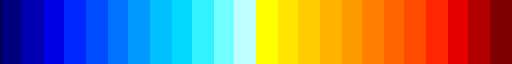

In [52]:
cmnew

In [53]:
def world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-1, inp_vmax=1):
    renamer = {}
    for i in df_d:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_d = df_d.rename(columns=renamer)

    renamer = {}
    for i in df_u:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_u = df_u.rename(columns=renamer)

    for i in df_u:
        if i != 'expver':
            df_u[i] = df_u[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    for i in df_d:
        if i != 'expver':
            df_d[i] = df_d[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    df_d = df_d[~np.isnan(df_d.fg_depar)]
    df_u = df_u[~np.isnan(df_u.fg_depar)]

    for p in [plev]:
        df_d_p = df_d[df_d.vertco_reference_1==p]
        df_u_p = df_u[df_u.vertco_reference_1==p]
    limit = [1,99]
    out = {'stat':[],'me':[],'lat':[],'lon':[], 'number':[]}
    for stat in df_u_p.statid.drop_duplicates():
        all_diffs = []
        df_u_stat = df_u_p[df_u_p.statid==stat]
        df_d_stat = df_d_p[df_d_p.statid==stat]
        # display(df_u_stat)
        # display(df_d_stat)
        for obs in range(len(df_u_stat)):
            df_i = df_u_stat.iloc[obs]
            df_comp = df_d_stat[np.logical_and(np.logical_and(df_d_stat.antime == df_i.antime, df_d_stat.andate == df_i.andate),df_d_stat.obsvalue == df_i.obsvalue)]
            if len(df_comp) > 1:
                # print()
                sel = np.argmin(np.abs(df_comp.time - df_i.time))
                # print(df_i.time, df_comp.iloc[sel].time)
                all_diffs.append(df_i.fg_depar - df_comp.iloc[sel].fg_depar)
            elif len(df_comp) < 1:
                continue
            else:
                all_diffs.append(df_i.fg_depar - df_comp.fg_depar.values[0])
        if len(all_diffs) > 2:
            out['stat'].append(stat)
            data = np.array(all_diffs)
            outlier_drop = np.nanpercentile(data, limit)
            data[data < outlier_drop[0]] = np.nan
            data[data > outlier_drop[1]] = np.nan
            out['me'].append(np.nanmean(data))
            out['lat'].append(df_u_stat.lat.iloc[0])
            out['lon'].append(df_u_stat.lon.iloc[0])
            out['number'].append(len(all_diffs))


    out_df = pd.DataFrame.from_dict(out)
    plt_world_map_diff(out_df, str(plev/100)+" hPa", year, var, inp_vmin, inp_vmax)
    plt_world_map_diff(out_df, "number of observations", year, var, 0, 200, number=True)
    
def plt_world_map_diff(lla, pl ,year, var, inp_vmin, inp_vmax, number = False):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    if number:
        plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                    c=lla["number"], 
                    cmap= cmnew,
                    vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
                  )
        ax.set_title(var+" " + ' ' + str(pl) + ' Pa ' + str(year))
        ax.grid()
        plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                    c=lla["me"], 
                    cmap= cmnew,
                    vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
                  )
        ax.set_title("ME difference "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
        ax.grid()
        plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
        plt.tight_layout()
        plt.show()
        fig.savefig("ME_difference_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
        plt.close()

In [54]:
def world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-1, inp_vmax=1):
    renamer = {}
    for i in df_d:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_d = df_d.rename(columns=renamer)

    renamer = {}
    for i in df_u:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_u = df_u.rename(columns=renamer)

    for i in df_u:
        if i != 'expver':
            df_u[i] = df_u[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    for i in df_d:
        if i != 'expver':
            df_d[i] = df_d[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    df_d = df_d[~np.isnan(df_d.fg_depar)]
    df_u = df_u[~np.isnan(df_u.fg_depar)]

    for p in [plev]:
        df_d_p = df_d[df_d.vertco_reference_1==p]
        df_u_p = df_u[df_u.vertco_reference_1==p]
    limit = [1,99]
    out = {'stat':[],'me':[],'lat':[],'lon':[], 'number':[]}
    for stat in df_u_p.statid.drop_duplicates():
        all_diffs = []
        df_u_stat = df_u_p[df_u_p.statid==stat]
        df_d_stat = df_d_p[df_d_p.statid==stat]
        # display(df_u_stat)
        # display(df_d_stat)
        for obs in range(len(df_u_stat)):
            df_i = df_u_stat.iloc[obs]
            df_comp = df_d_stat[np.logical_and(np.logical_and(df_d_stat.antime == df_i.antime, df_d_stat.andate == df_i.andate),df_d_stat.obsvalue == df_i.obsvalue)]
            if len(df_comp) > 1:
                # print()
                sel = np.argmin(np.abs(df_comp.time - df_i.time))
                # print(df_i.time, df_comp.iloc[sel].time)
                all_diffs.append(df_i.fg_depar - df_comp.iloc[sel].fg_depar)
            elif len(df_comp) < 1:
                continue
            else:
                all_diffs.append(df_i.fg_depar - df_comp.fg_depar.values[0])
        if len(all_diffs) > 2:
            out['stat'].append(stat)
            data = np.array(all_diffs)
            outlier_drop = np.nanpercentile(data, limit)
            data[data < outlier_drop[0]] = np.nan
            data[data > outlier_drop[1]] = np.nan
            out['me'].append(np.sqrt(np.nanmean(np.square(data))))
            out['lat'].append(df_u_stat.lat.iloc[0])
            out['lon'].append(df_u_stat.lon.iloc[0])
            out['number'].append(len(all_diffs))


    out_df = pd.DataFrame.from_dict(out)
    plt_world_map(out_df, str(plev/100)+" hPa", year, var, inp_vmin, inp_vmax)
    # plt_world_map(out_df, "number of observations", year, var, 0, 100, number=True)
    
def plt_world_map(lla, pl ,year, var, inp_vmin, inp_vmax, number = False):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    if number:
        plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                    c=lla["number"], 
                    cmap= cmnew,
                    vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
                  )
        ax.set_title(var+" " + ' ' + str(pl) + ' Pa ' + str(year))
        ax.grid()
        plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                    c=lla["me"], 
                    cmap= cmnew,
                    vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
                  )
        ax.set_title("RMSE "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
        ax.grid()
        plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
        plt.tight_layout()
        plt.show()
        fig.savefig("RMSE_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
        plt.close()

In [89]:
def world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-1, inp_vmax=1):
    renamer = {}
    for i in df_d:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_d = df_d.rename(columns=renamer)

    renamer = {}
    for i in df_u:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_u = df_u.rename(columns=renamer)

    for i in df_u:
        if i != 'expver':
            df_u[i] = df_u[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    for i in df_d:
        if i != 'expver':
            df_d[i] = df_d[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    df_d = df_d[~np.isnan(df_d.fg_depar)]
    df_u = df_u[~np.isnan(df_u.fg_depar)]

    for p in [plev]:
        df_d_p = df_d[df_d.vertco_reference_1==p]
        df_u_p = df_u[df_u.vertco_reference_1==p]
    limit = [1,99]
    out = {'stat':[],'me':[],'lat':[],'lon':[], 'number':[]}
    for stat in df_u_p.statid.drop_duplicates():
        all_diffs_d = []
        all_diffs_u = []
        df_u_stat = df_u_p[df_u_p.statid==stat]
        df_d_stat = df_d_p[df_d_p.statid==stat]
        # display(df_u_stat)
        # display(df_d_stat)
        for obs in range(len(df_u_stat)):
            df_i = df_u_stat.iloc[obs]
            df_comp = df_d_stat[np.logical_and(np.logical_and(df_d_stat.antime == df_i.antime, df_d_stat.andate == df_i.andate),df_d_stat.obsvalue == df_i.obsvalue)]
            if len(df_comp) > 1:
                # print()
                sel = np.argmin(np.abs(df_comp.time - df_i.time))
                # print(df_i.time, df_comp.iloc[sel].time)
                all_diffs_d.append(df_comp.iloc[sel].fg_depar)
                all_diffs_u.append(df_i.fg_depar)
            elif len(df_comp) < 1:
                continue
            else:
                all_diffs_d.append(df_comp.fg_depar.values[0])
                all_diffs_u.append(df_i.fg_depar)
        if len(all_diffs_u) > 2 and len(all_diffs_d) > 2:
            out['stat'].append(stat)
            
            data_u = np.array(all_diffs_u)
            outlier_drop_u = np.nanpercentile(data_u, limit)
            data_u[data_u < outlier_drop_u[0]] = np.nan
            data_u[data_u > outlier_drop_u[1]] = np.nan
            
            data_d = np.array(all_diffs_d)
            outlier_drop_d = np.nanpercentile(data_d, limit)
            data_d[data_d < outlier_drop_d[0]] = np.nan
            data_d[data_d > outlier_drop_d[1]] = np.nan
            
            out['me'].append(np.sqrt(np.nanmean(np.square(data_u))) - np.sqrt(np.nanmean(np.square(data_d))))
            out['lat'].append(df_u_stat.lat.iloc[0])
            out['lon'].append(df_u_stat.lon.iloc[0])
            out['number'].append(len(all_diffs_u))


    out_df = pd.DataFrame.from_dict(out)
    plt_world_map_rmse_diff(out_df, str(plev/100)+" hPa", year, var, inp_vmin, inp_vmax)
    # plt_world_map(out_df, "number of observations", year, var, 0, 100, number=True)
    
def plt_world_map_rmse_diff(lla, pl ,year, var, inp_vmin, inp_vmax, number = False):    
    fig, ax = plt.subplots(figsize=(18,10))# plot map on axis
    countries = gpd.read_file(  
    #      gpd.datasets.get_path("naturalearth_lowres"))countries[countries["name"] == "Australia"].plot(color="lightgrey",
    #                                                  ax=ax)# parse dates for plot's title
        gpd.datasets.get_path("naturalearth_lowres")).plot(color="lightgrey", ax=ax)# parse dates for plot's title
    plt1 = ax.scatter(x=lla["lon"], y=lla["lat"],
                c=lla["me"], 
                cmap= cmnew,
                vmin=inp_vmin, vmax=inp_vmax, #edgecolor='k',
              )
    ax.set_title("RMSE difference "+var+" " + ' ' + str(pl) + ' Pa ' + str(year))
    ax.grid()
    plt.colorbar(plt1, orientation='horizontal', shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.show()
    fig.savefig("RMSE_diff_"+var+"_" + str(pl) + '_Pa_' + str(year) + '.png')
    plt.close()

In [90]:
np.nanmin(df_u['        andate'])

19800601

In [91]:
np.nanmax(df_u['        andate'])

19800731

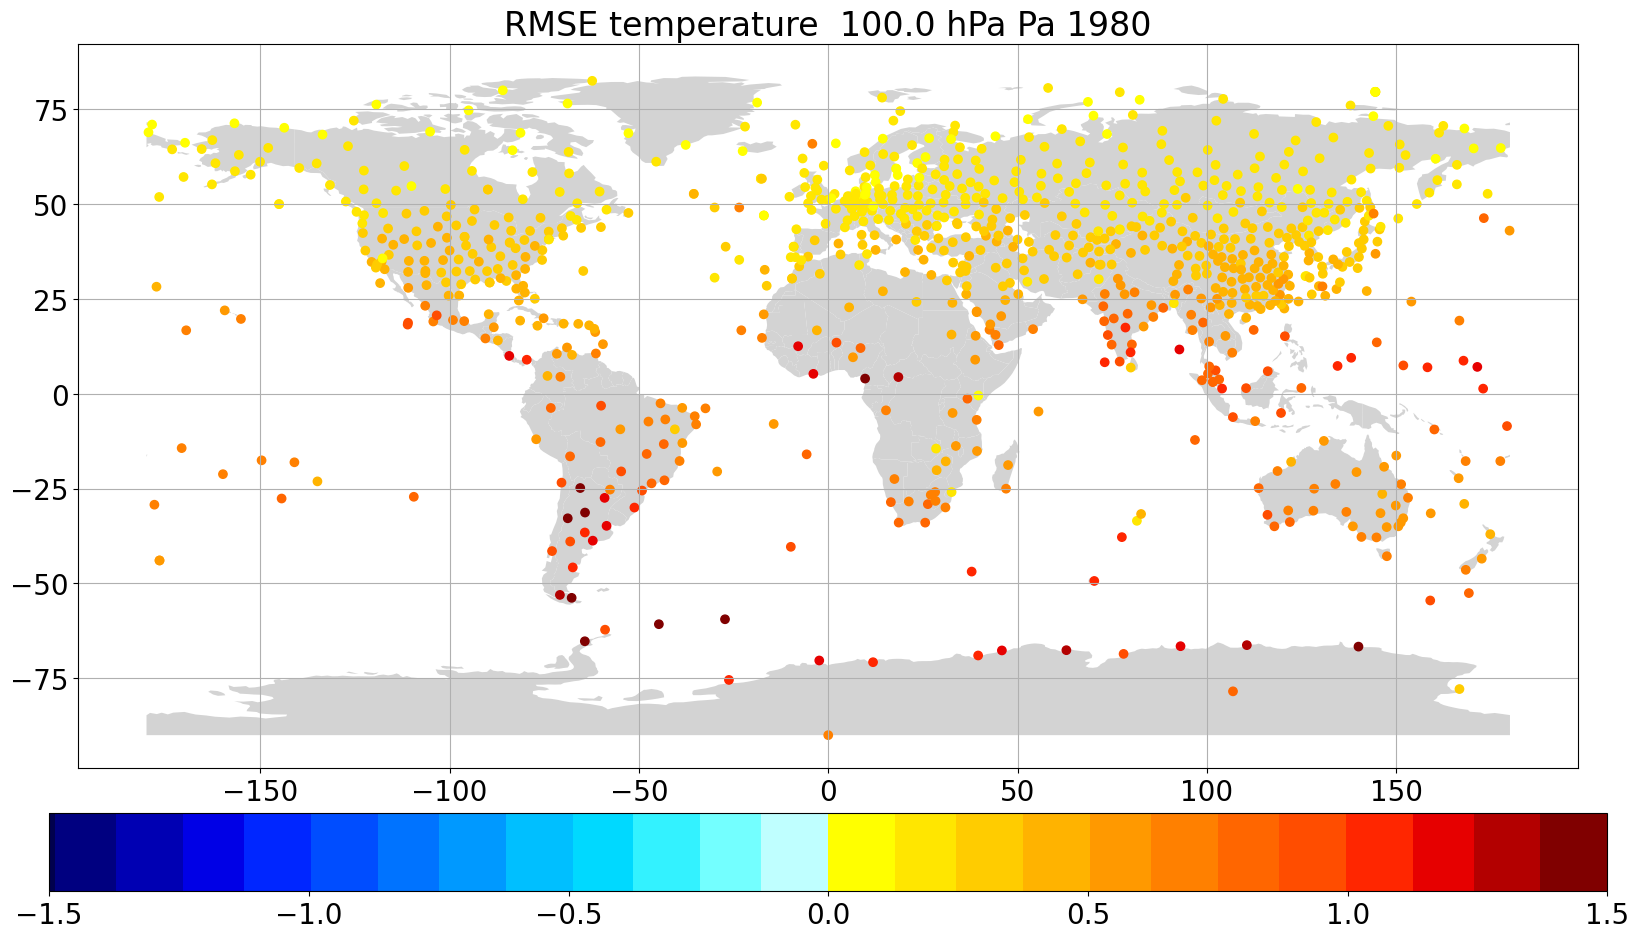

In [66]:
var = 'temperature'
year = '1980'
plev = 10000

df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4671.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4675.csv', delimiter='\t')

world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)


In [71]:
df_u

,varno@body,lat@hdr,lon@hdr,reportype,obsvalue@body,vertco_reference_1@body,andate,antime,time@hdr,reportno@hdr,statid@hdr,fg_depar@body,expver
0,2,37.380001,136.899994,16045,NULL,101200.0,19800601,120000,180000,295,'47600',NULL,'4671'
1,2,37.380001,136.899994,16045,NULL,100000.0,19800601,120000,180000,295,'47600',NULL,'4671'
2,2,37.380001,136.899994,16045,NULL,92500.0,19800601,120000,180000,295,'47600',NULL,'4671'
3,2,37.380001,136.899994,16045,NULL,91600.0,19800601,120000,180000,295,'47600',NULL,'4671'
4,2,37.380001,136.899994,16045,NULL,85000.0,19800601,120000,180000,295,'47600',NULL,'4671'
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4207519,2,66.000000,1.500000,16046,225.110001,4800.0,19800731,120000,180000,4573,'C7M00',-0.029188,'4671'
4207520,2,66.000000,1.500000,16046,227.500000,3000.0,19800731,120000,180000,4573,'C7M00',1.656687,'4671'
4207521,2,66.000000,1.500000,16046,228.100006,2200.0,19800731,120000,180000,4573,'C7M00',-0.158258,'4671'
4207522,2,66.000000,1.500000,16046,229.899994,2000.0,19800731,120000,180000,4573,'C7M00',0.297710,'4671'


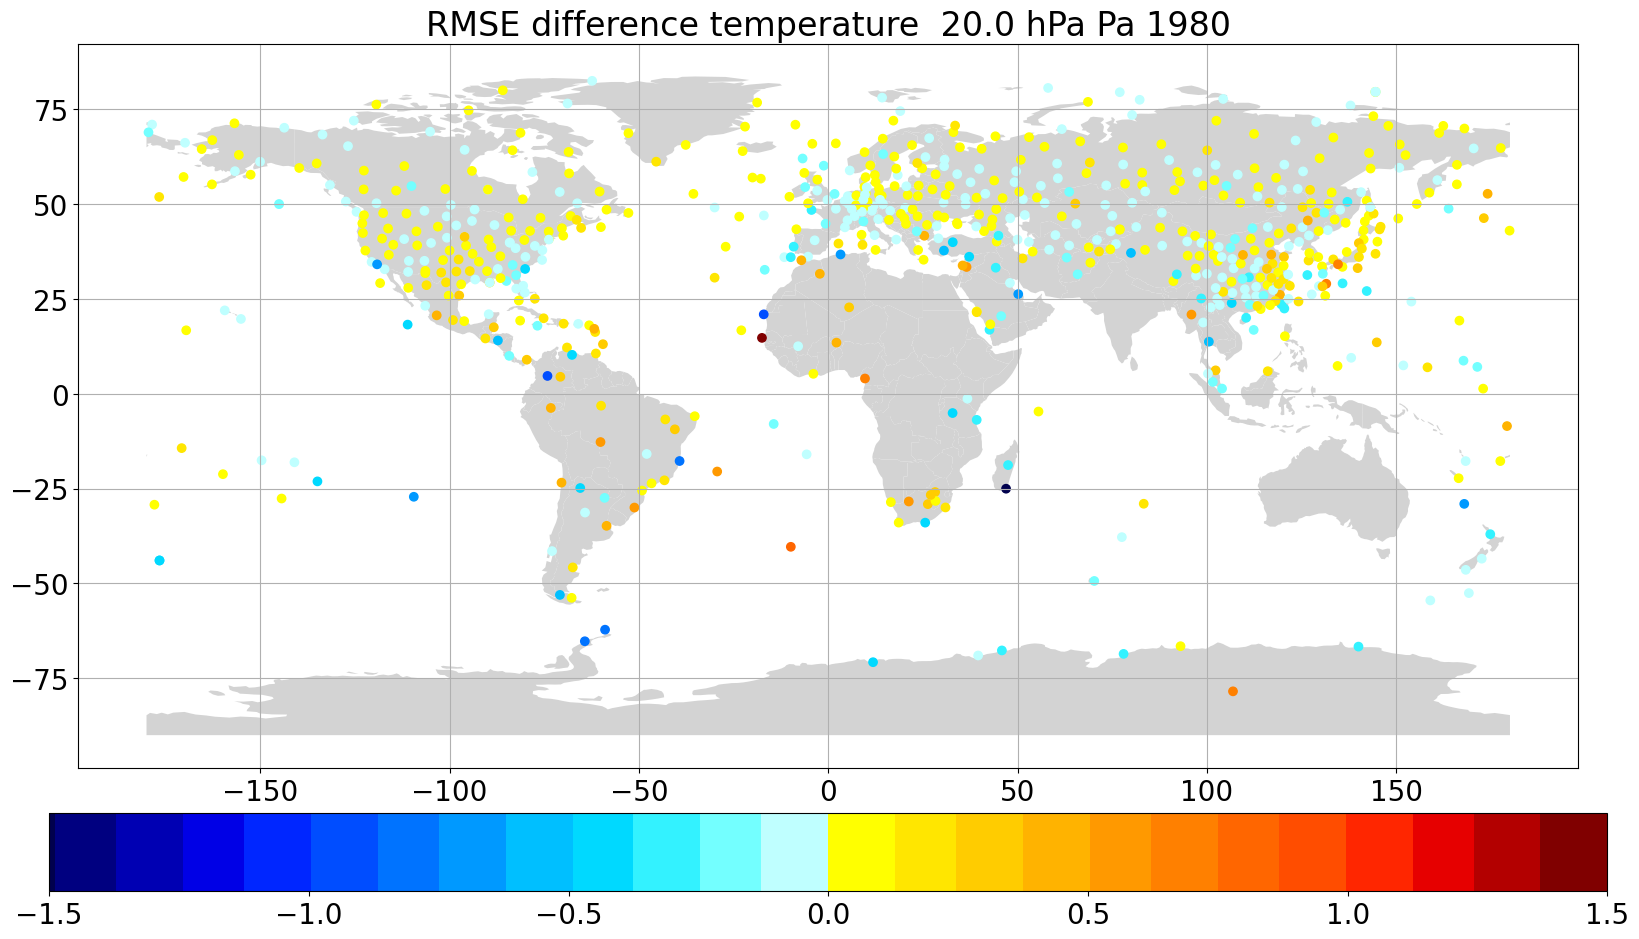

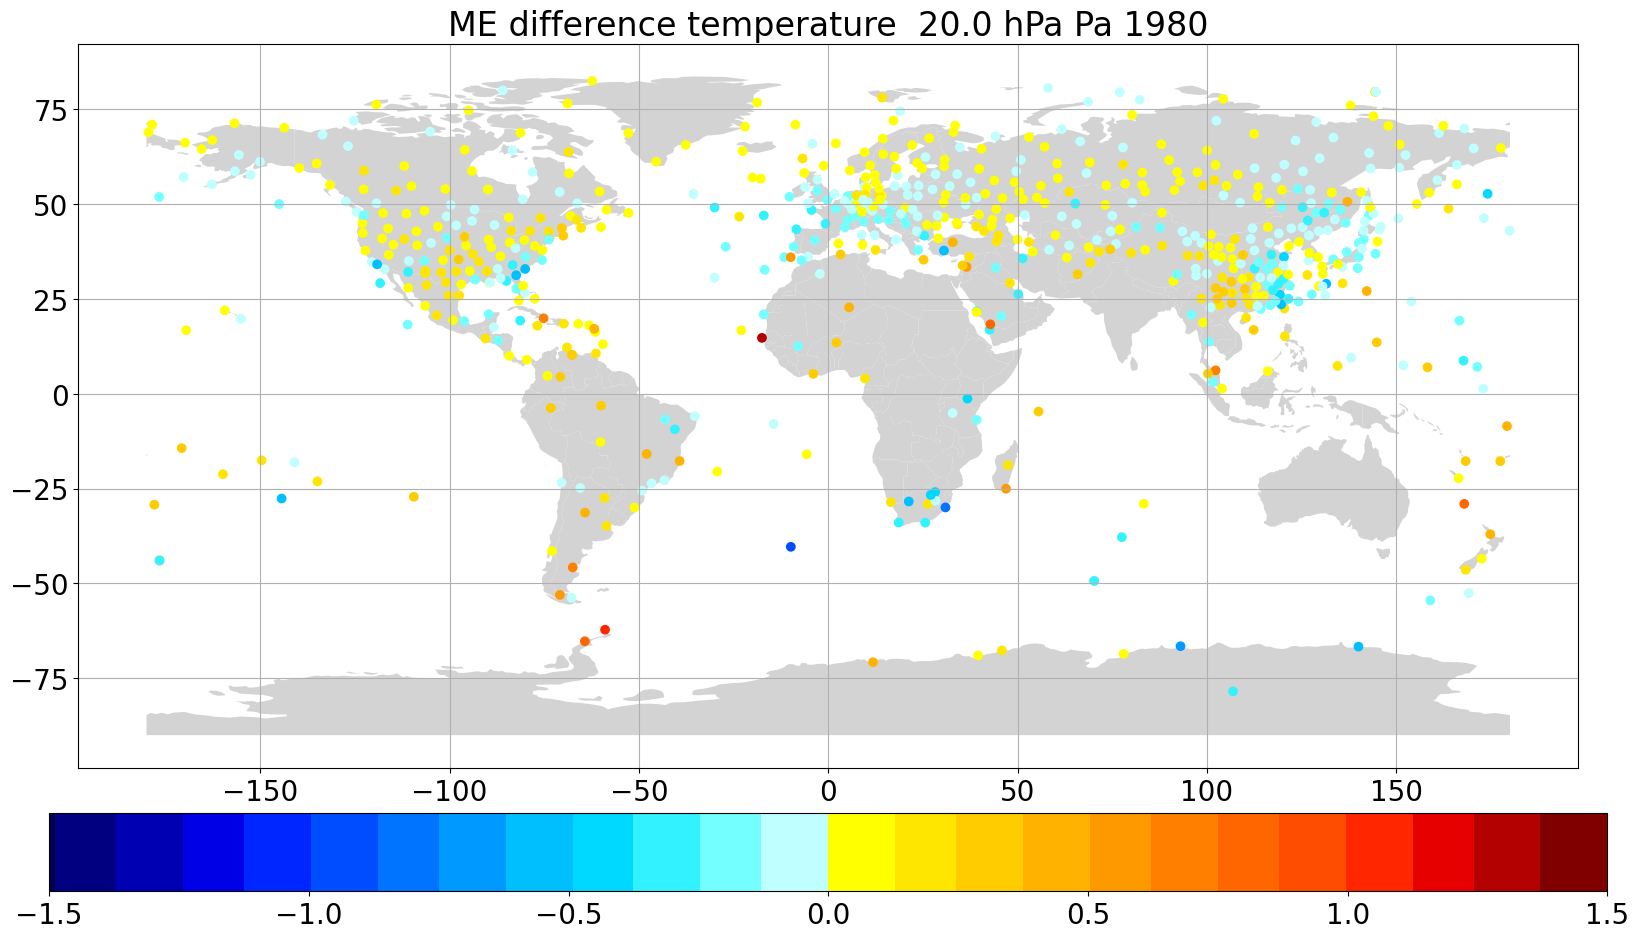

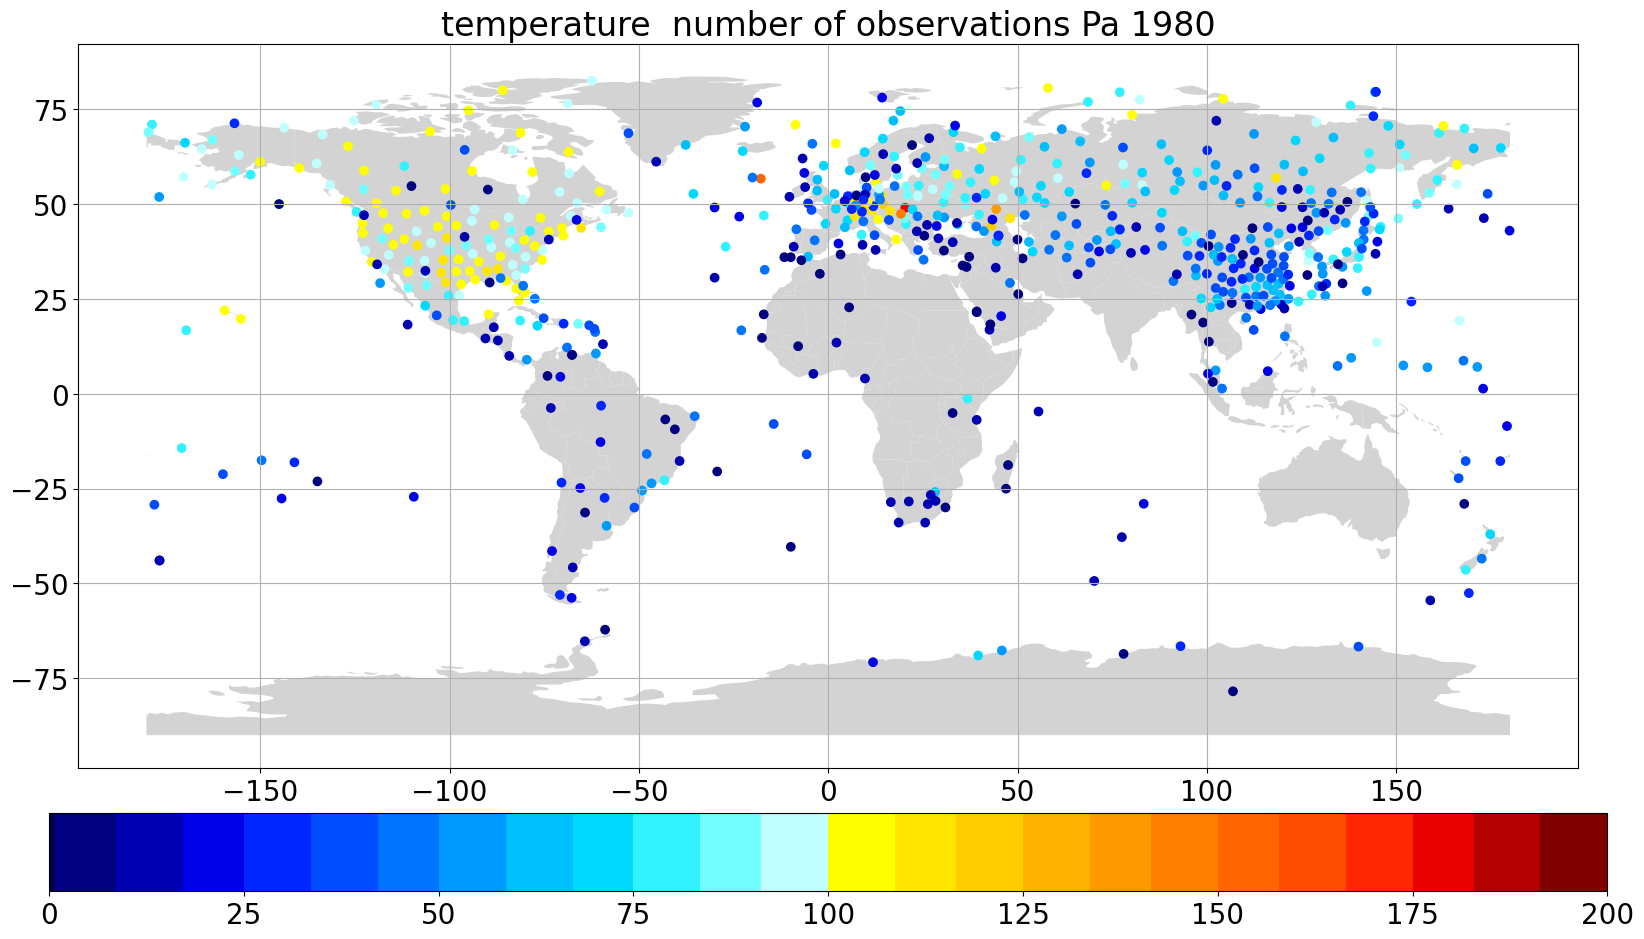

In [95]:
var = 'temperature'
year = '1980'
plev = 2000

df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4671_t.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4675_t.csv', delimiter='\t')

world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)
# world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)
world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)


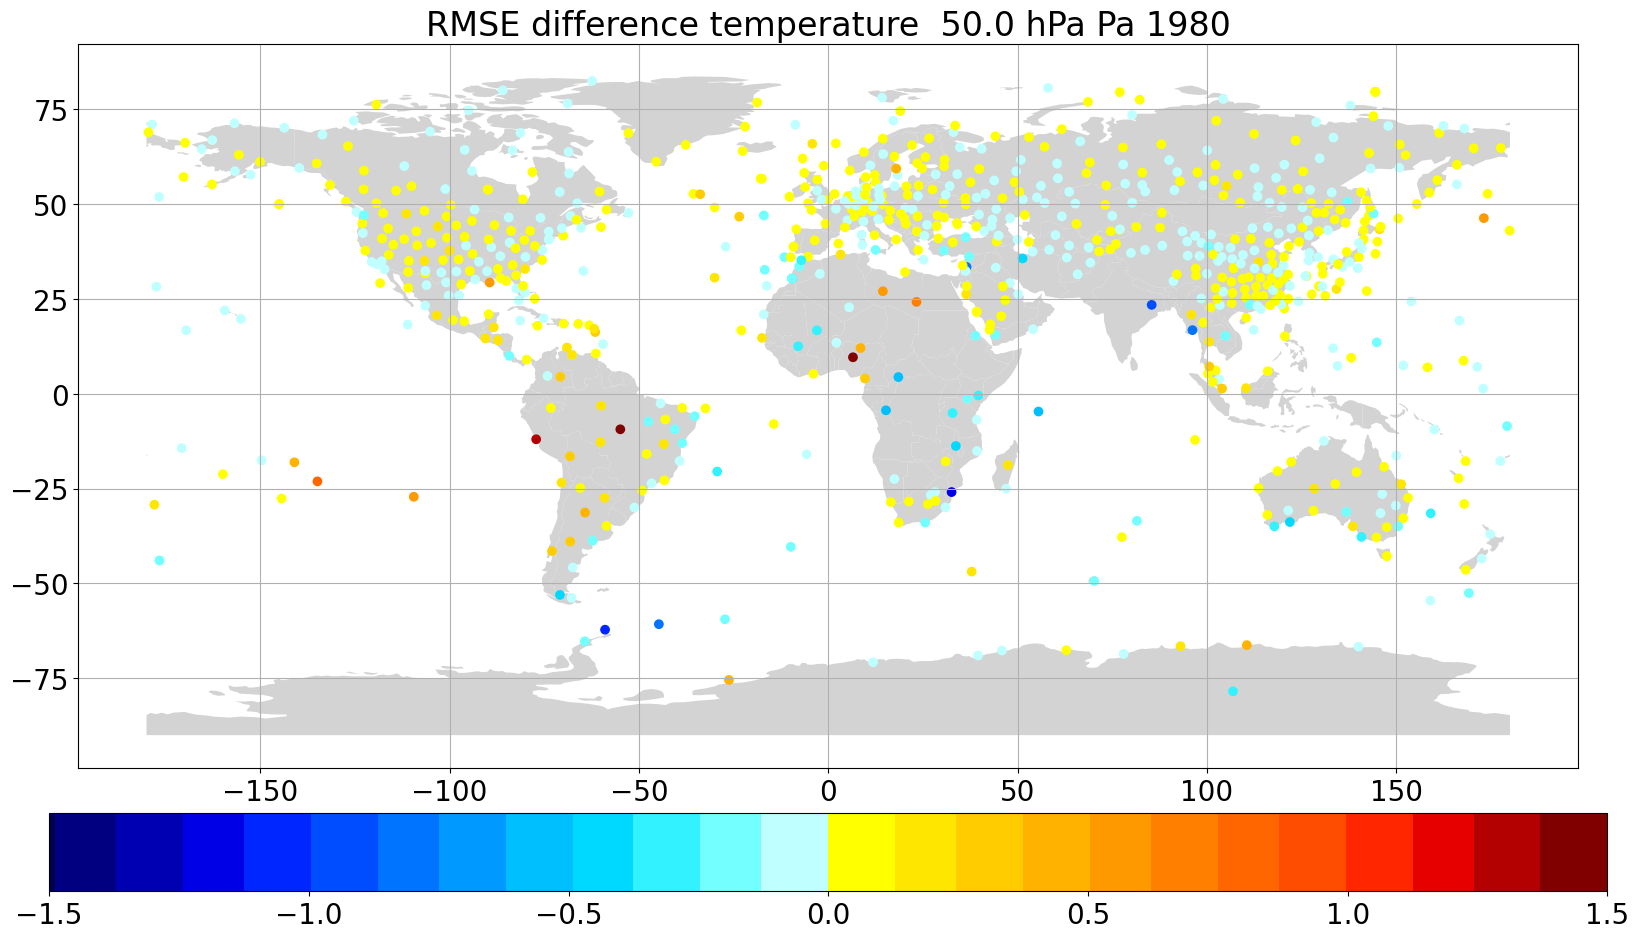

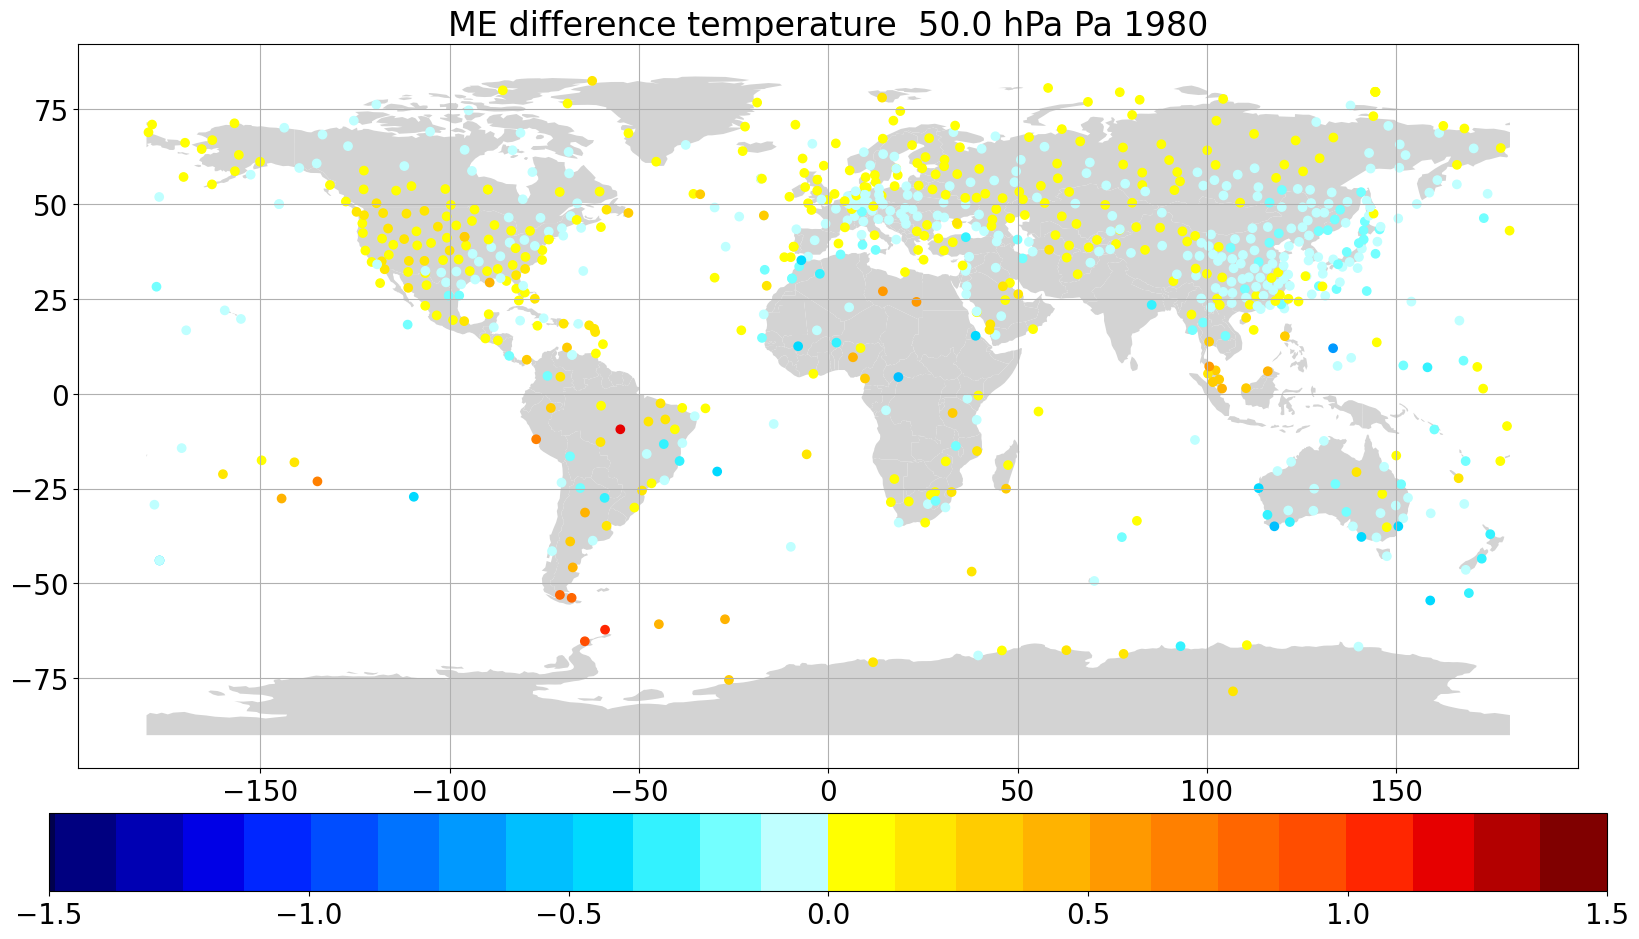

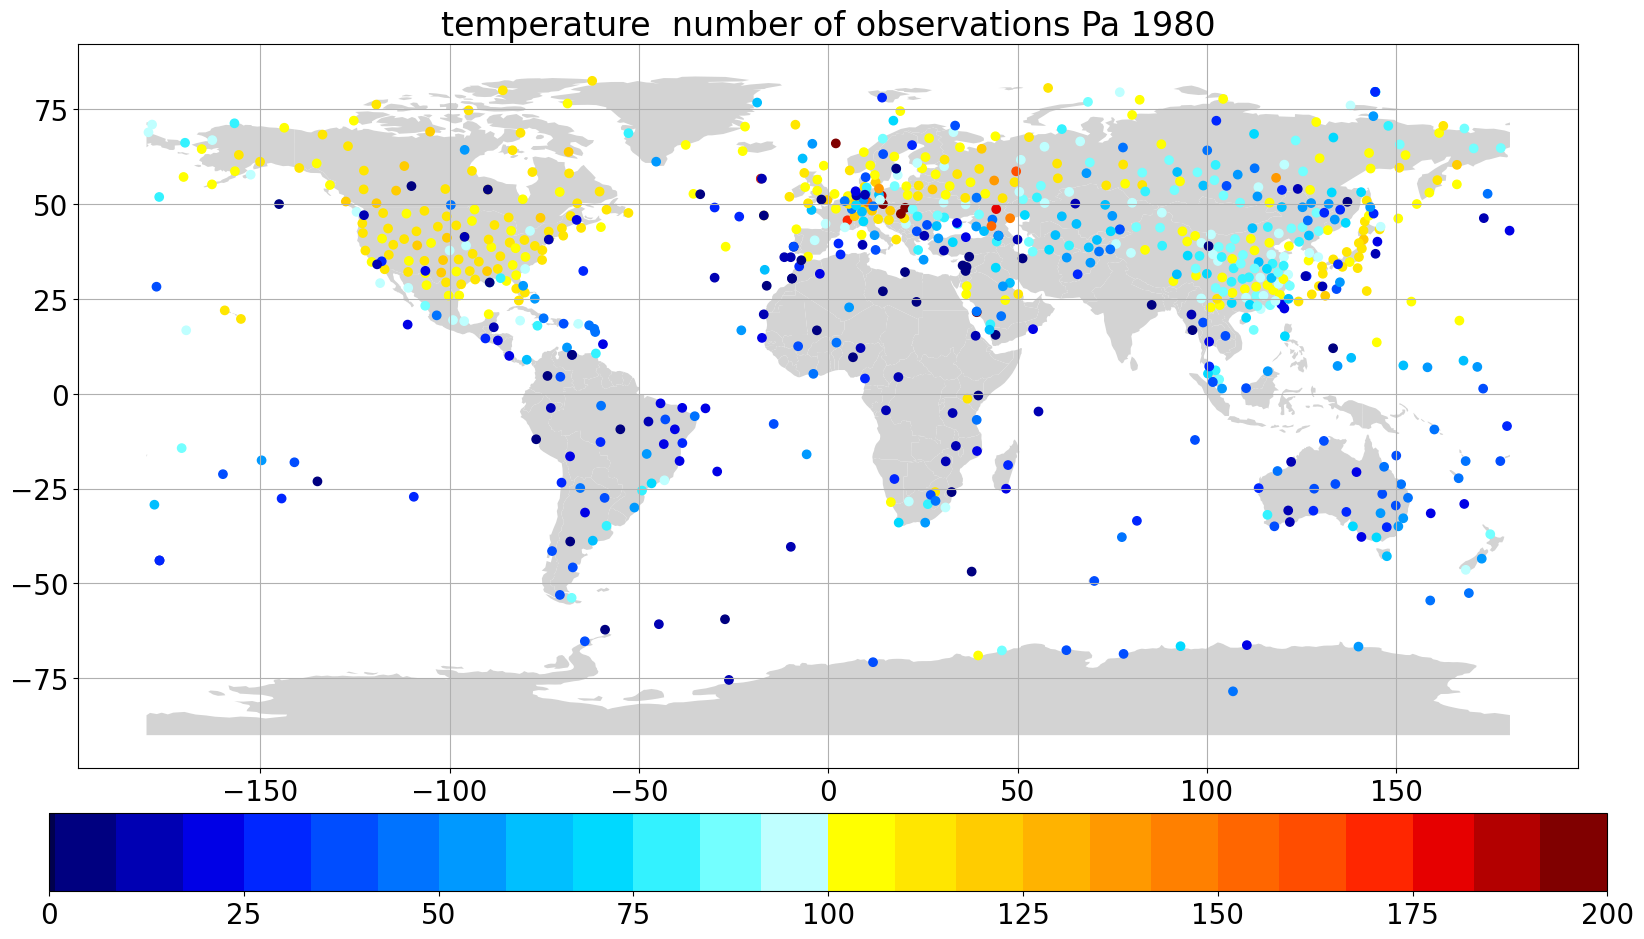

In [93]:
var = 'temperature'
year = '1980'
plev = 5000

df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4671_t.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4675_t.csv', delimiter='\t')

world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)
# world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)
world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)


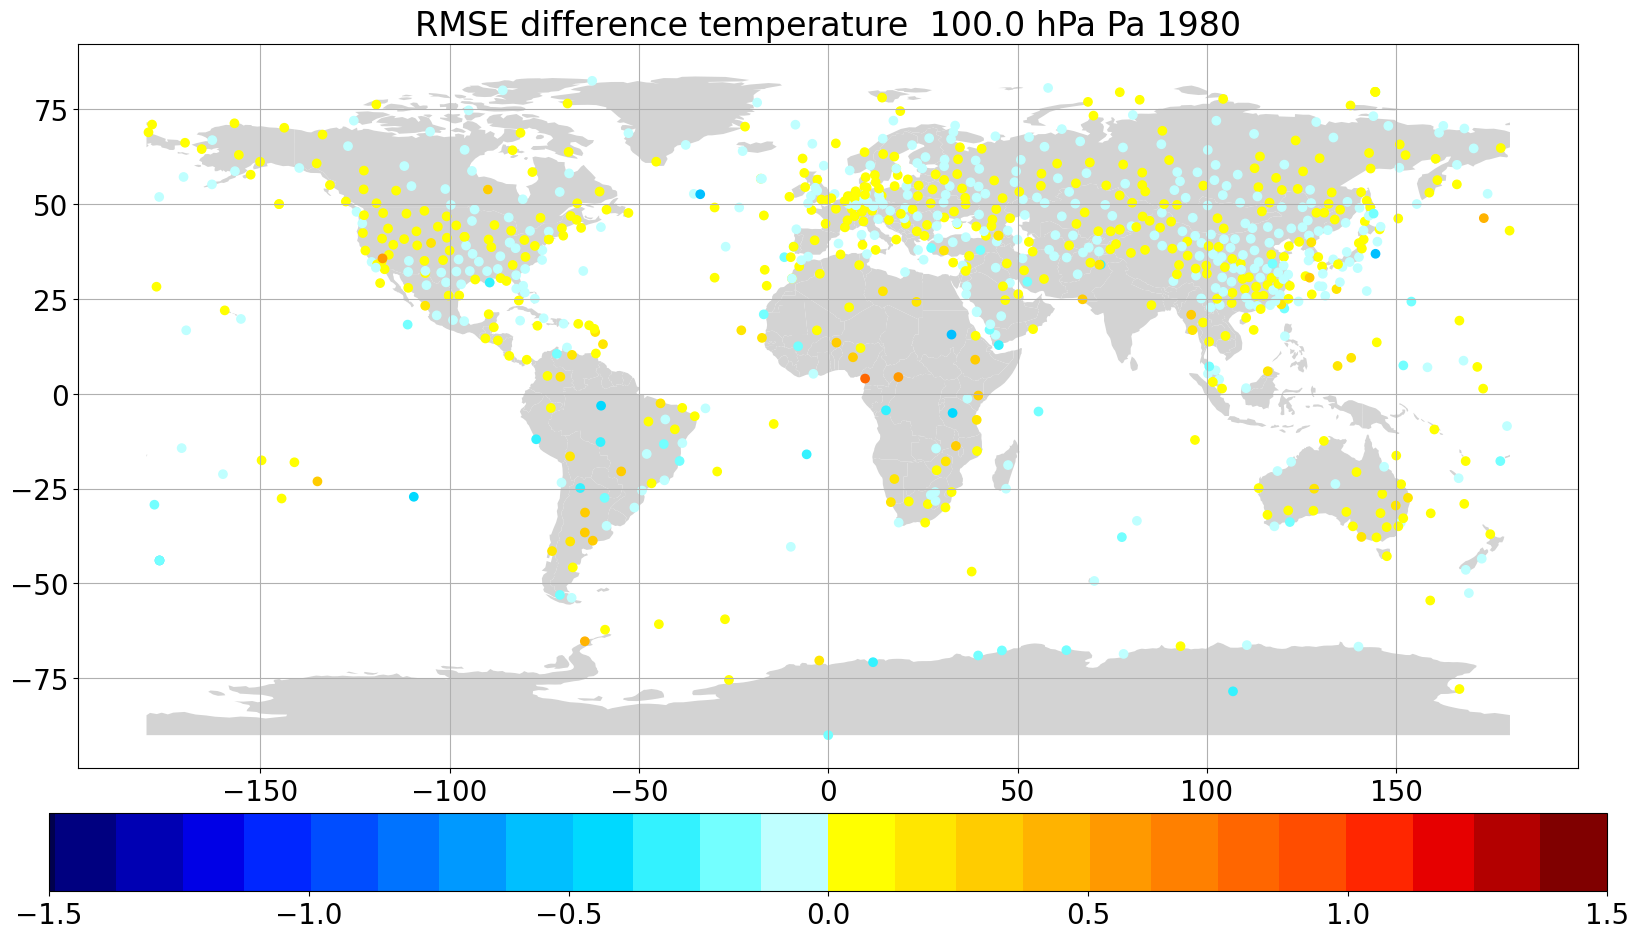

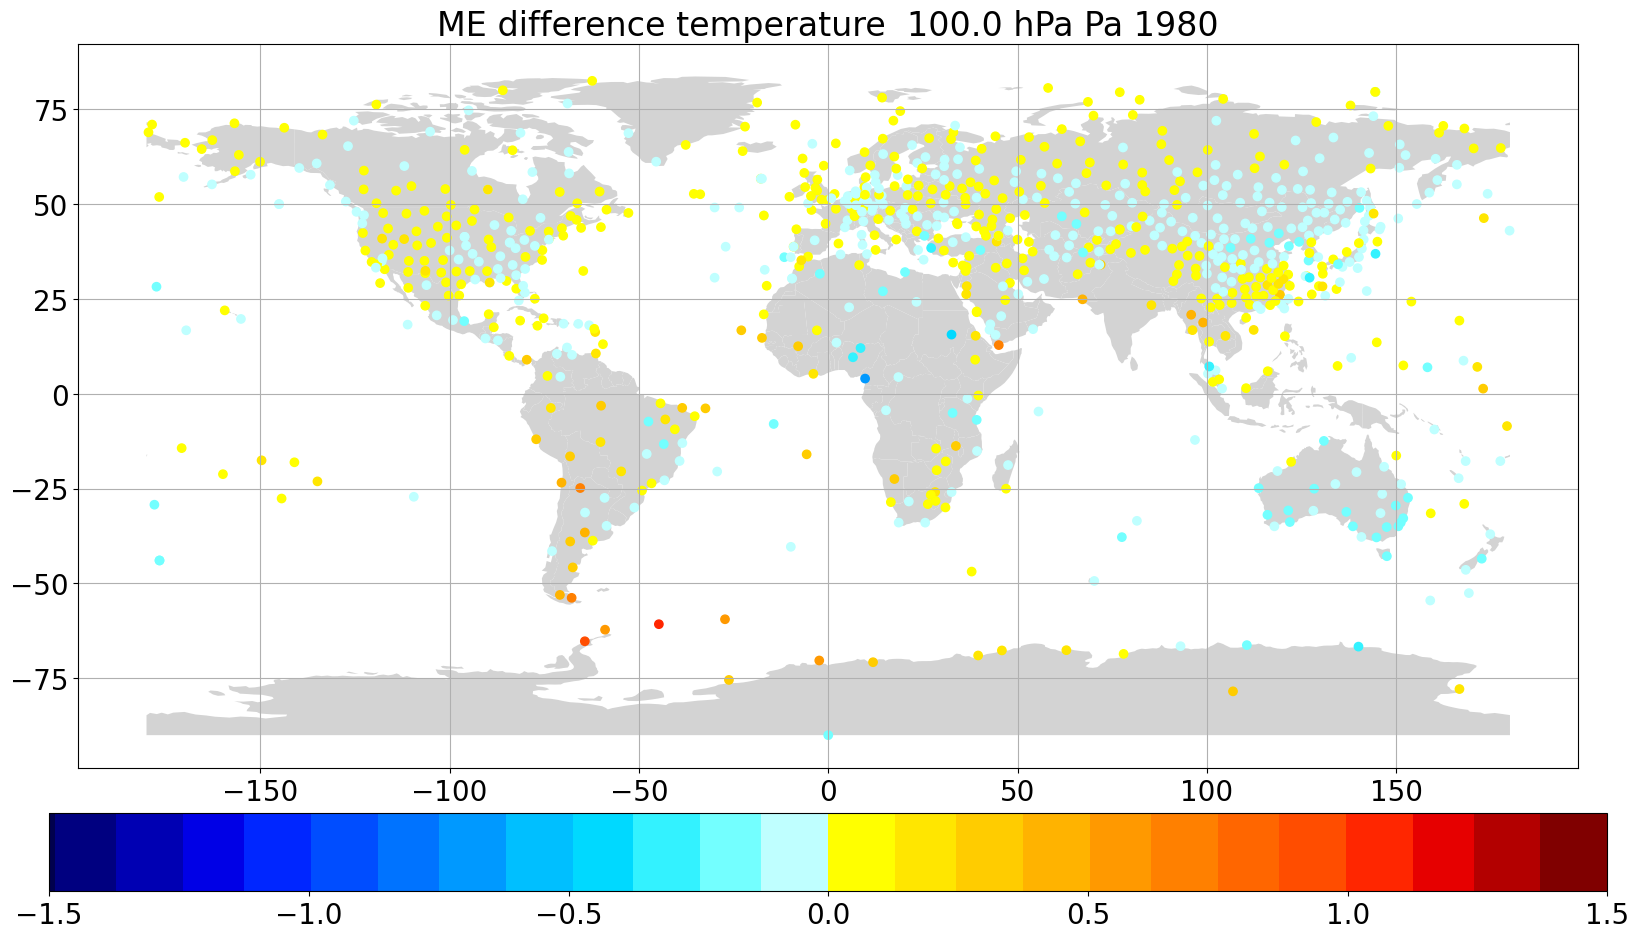

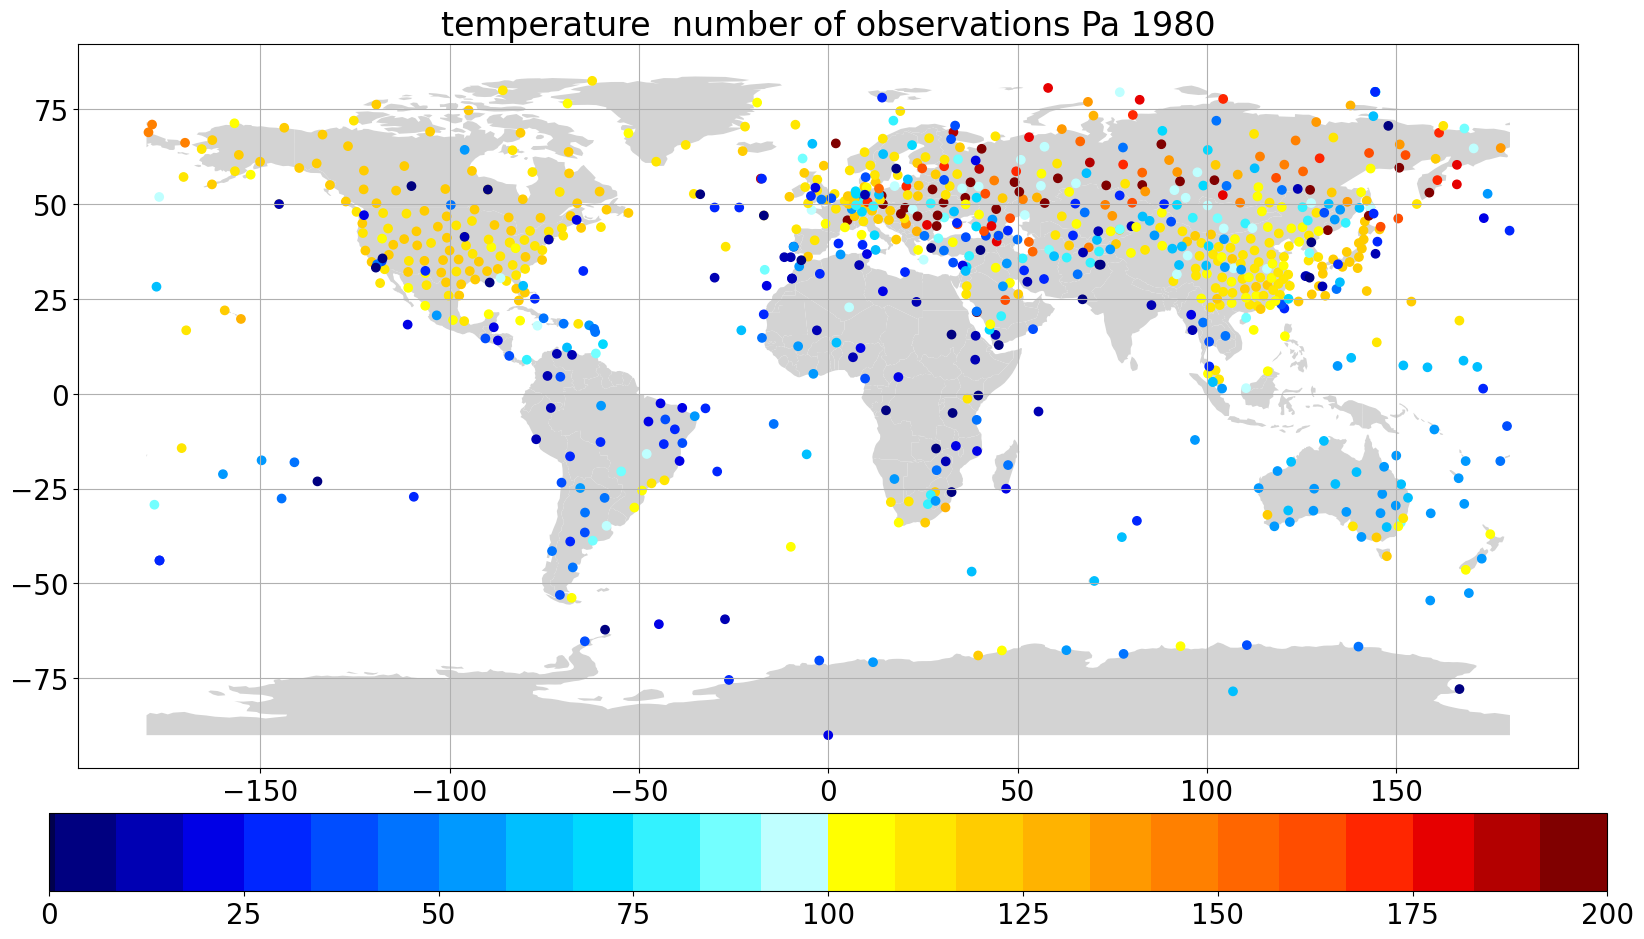

In [94]:
var = 'temperature'
year = '1980'
plev = 10000

df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4671_t.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4675_t.csv', delimiter='\t')

world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)
# world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)
world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-1.5, inp_vmax=1.5)

In [84]:
# var = 'humidity'
# year = '1980'
# plev = 10000

# df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4671.csv', delimiter='\t')
# df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4675.csv', delimiter='\t')

# world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-0.5, inp_vmax=0.5)
# # world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-0.5, inp_vmax=0.5)
# world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-0.5, inp_vmax=0.5)


In [85]:
# var = 'u'
# year = '1980'
# plev = 10000

# df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4671.csv', delimiter='\t')
# df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4675.csv', delimiter='\t')

# world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-10, inp_vmax=10)
# # world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-10, inp_vmax=10)
# world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-10, inp_vmax=10)


In [86]:
# var = 'v'
# year = '1980'
# plev = 10000

# df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4671.csv', delimiter='\t')
# df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/p_data_4675.csv', delimiter='\t')

# world_map_rmse_diff(df_u, df_d, plev, var, year, inp_vmin=-5, inp_vmax=5)
# # world_map_rmse(df_u, df_d, plev, var, year, inp_vmin=-5, inp_vmax=5)
# world_map_diffs(df_u, df_d, plev, var, year, inp_vmin=-5, inp_vmax=5)


In [79]:
def rmse_diff(df_u, df_d, var, year, inp_vmin=-1, inp_vmax=1):
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
    renamer = {}
    for i in df_d:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_d = df_d.rename(columns=renamer)

    renamer = {}
    for i in df_u:
        if '@' in i:
            renamer[i]=i.replace(' ','').split('@')[0]
        else:
            renamer[i]=i.replace(' ','')
    df_u = df_u.rename(columns=renamer)

    for i in df_u:
        if i != 'expver':
            df_u[i] = df_u[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    for i in df_d:
        if i != 'expver':
            df_d[i] = df_d[i].replace({'          NULL':np.nan}).astype('float', errors='ignore')

    df_d = df_d[~np.isnan(df_d.fg_depar)]
    df_u = df_u[~np.isnan(df_u.fg_depar)]
    
    ret_out = {}
    for i in ['rmse_sum_shbase_sonde', 'rmse_sum_shdisp_sonde']:
        ret_out[i]={}
        for p in plevs:
            ret_out[i][p] = []
            
    for p in plevs:
        df_d_p = df_d[df_d.vertco_reference_1==p]
        df_u_p = df_u[df_u.vertco_reference_1==p]
        limit = [1,99]
        # out = {'stat':[],'me':[],'lat':[],'lon':[], 'number':[]}
        for stat in df_u_p.statid.drop_duplicates():
            all_diffs_d = []
            all_diffs_u = []
            df_u_stat = df_u_p[df_u_p.statid==stat]
            df_d_stat = df_d_p[df_d_p.statid==stat]
            # display(df_u_stat)
            # display(df_d_stat)
            for obs in range(len(df_u_stat)):
                df_i = df_u_stat.iloc[obs]
                df_comp = df_d_stat[np.logical_and(np.logical_and(df_d_stat.antime == df_i.antime, df_d_stat.andate == df_i.andate),df_d_stat.obsvalue == df_i.obsvalue)]
                if len(df_comp) > 1:
                    # print()
                    sel = np.argmin(np.abs(df_comp.time - df_i.time))
                    # print(df_i.time, df_comp.iloc[sel].time)
                    all_diffs_d.append(df_comp.iloc[sel].fg_depar)
                    all_diffs_u.append(df_i.fg_depar)
                elif len(df_comp) < 1:
                    continue
                else:
                    all_diffs_d.append(df_comp.fg_depar.values[0])
                    all_diffs_u.append(df_i.fg_depar)
            if len(all_diffs_u) > 2 and len(all_diffs_d) > 2:
                # out['stat'].append(stat)

                data_u = np.array(all_diffs_u)
                outlier_drop_u = np.nanpercentile(data_u, limit)
                data_u[data_u < outlier_drop_u[0]] = np.nan
                data_u[data_u > outlier_drop_u[1]] = np.nan

                data_d = np.array(all_diffs_d)
                outlier_drop_d = np.nanpercentile(data_d, limit)
                data_d[data_d < outlier_drop_d[0]] = np.nan
                data_d[data_d > outlier_drop_d[1]] = np.nan

                ret_out['rmse_sum_shbase_sonde'][p].append(data_u)
                ret_out['rmse_sum_shdisp_sonde'][p].append(data_d)
                # out['lat'].append(df_u_stat.lat.iloc[0])
                # out['lon'].append(df_u_stat.lon.iloc[0])
                # out['number'].append(len(all_diffs_u))
                
    return ret_out


In [80]:
var = '_t' 
year = '1980'

df_u = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4671'+var+'.csv', delimiter='\t')
df_d = pd.read_csv('/users/staff/uvoggenberger/scratch/paul_data/pa_data_4675'+var+'.csv', delimiter='\t')

results = rmse_diff(df_u, df_d, var, year)

with open('pp_'+year+'_'+var+'_rmse_data.p', 'wb') as file:
    pickle.dump(results, file)

In [34]:
# var = 'rh' # '_rh'
# year = '1980'

# df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671'+var+'.csv', delimiter='\t')
# df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675'+var+'.csv', delimiter='\t')

# results = rmse_diff(df_u, df_d, var, year)

# with open('pp_'+year+'_'+var+'_rmse_data.p', 'wb') as file:
#     pickle.dump(results, file)

In [36]:
# var = 'u' # '_rh'
# year = '1980'

# df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671'+var+'.csv', delimiter='\t')
# df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675'+var+'.csv', delimiter='\t')

# results = rmse_diff(df_u, df_d, var, year)

# with open('pp_'+year+'_'+var+'_rmse_data.p', 'wb') as file:
#     pickle.dump(results, file)

In [37]:
# var = 'v' # '_rh'
# year = '1980'

# df_u = pd.read_csv('/users/staff/uvoggenberger/p_data_4671'+var+'.csv', delimiter='\t')
# df_d = pd.read_csv('/users/staff/uvoggenberger/p_data_4675'+var+'.csv', delimiter='\t')

# results = rmse_diff(df_u, df_d, var, year)

# with open('pp_'+year+'_'+var+'_rmse_data.p', 'wb') as file:
#     pickle.dump(results, file)

valid ascents:  95284


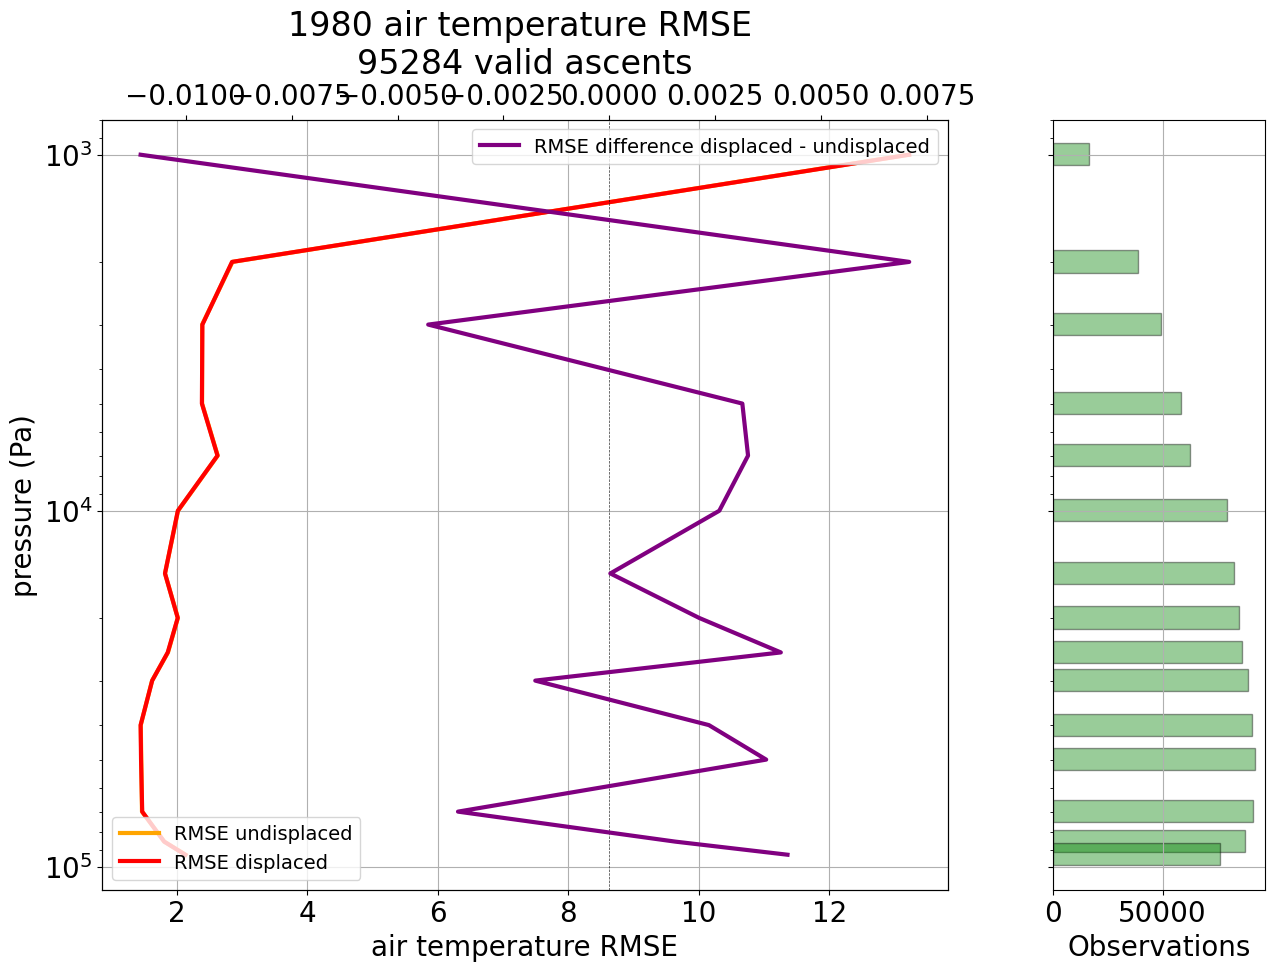

RMSE calculation:  0.8634853363037109
valid ascents:  86778


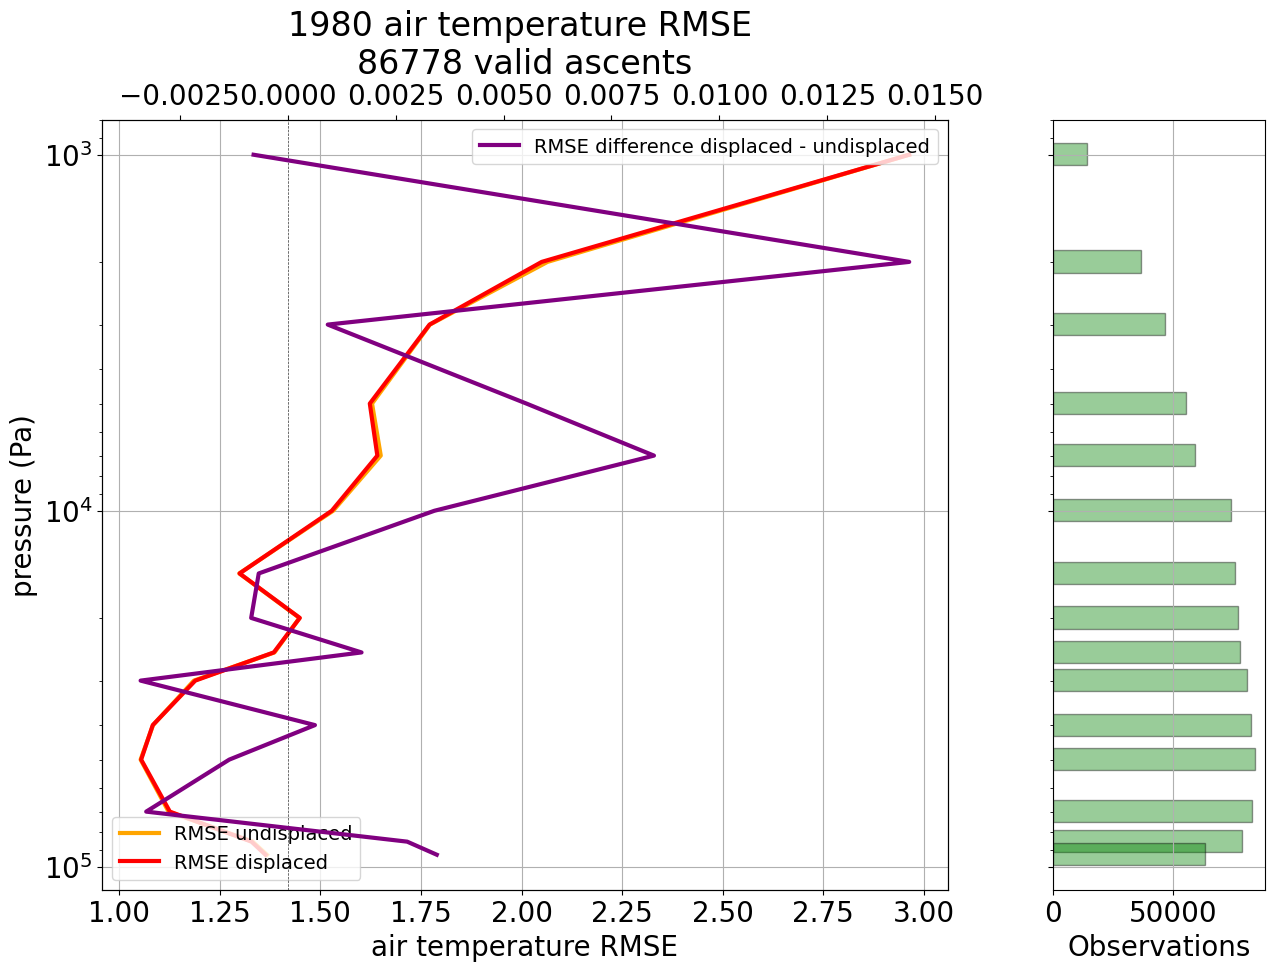

RMSE calculation:  0.878171443939209


In [172]:
# for file, name in [('pp_1980__rmse_data.p','air temperature'), ('pp_1980_u_rmse_data.p','eastward windspeed'), ('pp_1980_v_rmse_data.p','northward windspeed'), ('pp_1980_rh_rmse_data.p','relative humidity')]:
for file, name in [('pp_1980__rmse_data.p','air temperature'), ('pp_1980__t_rmse_data.p','air temperature')]:

    results = pickle.load(open(file, 'rb'))
    save_dict = {'eastward windspeed':'u', 'northward windspeed':'v', 'air temperature':'temperature', 'relative humidity':'rh'}
    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    diff = True
    show_date = False
    for var in [name]: #['eastward windspeed', 'northward windspeed', 'air temperature', 'relative humidity']:
        for year in [1980]:
            rmse_sum_shbase_sonde = {}
            rmse_sum_shdisp_sonde = {}
            for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:

                for results_iterator in range(len(results['rmse_sum_shbase_sonde'][k])):
                    if results_iterator == 0:
                        rmse_sum_shbase_sonde[k]  = results['rmse_sum_shbase_sonde'][k][results_iterator]
                    else:
                        rmse_sum_shbase_sonde[k]  = np.append(rmse_sum_shbase_sonde[k], results['rmse_sum_shbase_sonde'][k][results_iterator])

                for results_iterator in range(len(results['rmse_sum_shdisp_sonde'][k])):
                    if results_iterator == 0:
                        rmse_sum_shdisp_sonde[k] = results['rmse_sum_shdisp_sonde'][k][results_iterator]
                    else:
                        rmse_sum_shdisp_sonde[k] = np.append(rmse_sum_shdisp_sonde[k], results['rmse_sum_shdisp_sonde'][k][results_iterator])

            print('valid ascents: ', len(rmse_sum_shbase_sonde[50000]))
            t0 = time.time()
            rmse_shbase_sonde=[]
            rmse_shdisp_sonde=[]
            # rms_dispmbase=[]

            for i in range(len(stdplevs)):
                rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
                rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
                # rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))

            fig, ax = maplt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (15,10))
            ax1 = ax[0]
            ax2 = ax[1] 
            ax1.set_yscale('log')
            ax2.set_yscale('log')
            ax2.sharey(ax1)
            ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='RMSE undisplaced')
            ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='RMSE displaced')

            ax1_4 = ax1.twiny()
            ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
            if diff:
                ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='RMSE difference displaced - undisplaced')
            # ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='RMS displaced - undisplaced')

            ax1_4.legend(loc='upper right', prop={'size':14})
            ax1.set_ylim(ax1.get_ylim()[::-1])
            ax1.set_ylabel('pressure (Pa)')
            ax1.set_xlabel(var+' RMSE')
            ax1.legend(loc='lower left', prop={'size':14})
            ax1.grid()
    
            value_nr = []
            for i in rmse_sum_shbase_sonde:
                value_nr.append(len(np.asarray(rmse_sum_shbase_sonde[i])[~np.isnan(rmse_sum_shbase_sonde[i])]))
            ax2.barh(stdplevs, value_nr, np.array(stdplevs)/7, color='g', alpha = 0.4, align='center' ,ec="k")
            ax2.set_xlabel('Observations')
            ax2.tick_params(labelleft=False)
            ax2.grid()
            
            
            maplt.title(str(year)+' '+var+' RMSE \n' +str(len(rmse_sum_shbase_sonde[50000])) +' valid ascents')
            maplt.savefig(str(year)+'_'+save_dict[var]+'_era5_fc_world_rmse_plot_igra.png')
            maplt.show()
            maplt.close()
            print('RMSE calculation: ', time.time()-t0)

In [142]:
np.flip(2000 / np.log(stdplevs))

array([174.90216964, 176.20514241, 179.27170031, 184.84667129,
       188.73916582, 194.00612903, 197.49904776, 201.9490598 ,
       207.99089625, 217.14724095, 225.89514097, 234.8191423 ,
       249.80117177, 263.12664985, 289.5296546 ])

In [132]:
np.log(1000) = 2000 - np.log(x)

[1000,
 2000,
 3000,
 5000,
 7000,
 10000,
 15000,
 20000,
 25000,
 30000,
 40000,
 50000,
 70000,
 85000,
 92500]

In [141]:
np.exp(2000 - np.log(stdplevs))

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf])

In [139]:
np.log(1000) * 289.5296546021679

2000.0

In [118]:
np.log(2000)/stdplevs

array([7.60090246e-03, 3.80045123e-03, 2.53363415e-03, 1.52018049e-03,
       1.08584321e-03, 7.60090246e-04, 5.06726831e-04, 3.80045123e-04,
       3.04036098e-04, 2.53363415e-04, 1.90022561e-04, 1.52018049e-04,
       1.08584321e-04, 8.94223819e-05, 8.21719185e-05])

In [116]:
np.log(2000)

7.600902459542082

In [117]:
stdplevs

[1000,
 2000,
 3000,
 5000,
 7000,
 10000,
 15000,
 20000,
 25000,
 30000,
 40000,
 50000,
 70000,
 85000,
 92500]